In [28]:
import numpy as np
from datetime import datetime
from core.trade_service.traders.base import BaseTrader
from core.trade_service.instruments.moving_averages import MA


class DMA_Trader(BaseTrader):
    def __init__(self,
                 mode='test',
                 symbol='BTCUSDT',
                 interval_source='5m',
                 interval_group='1h',
                 on_investment: bool = False,
                 column_name: str = 'close',
                 period_short: int = 3,
                 period_long: int = 10,
                 panic=-0.01,
                 delta_buy=0,
                 delta_sell=0,
                 start_time=datetime.fromisoformat('2020-01-01 00:00:00')
                 ):
        super().__init__(mode, symbol, interval_source, interval_group, start_time, on_investment)
        self.period_short = period_short
        self.period_long = period_long
        self.column_name = column_name
        self.ma_short: MA
        self.ma_long: MA
        self.restart()
        self.panic = panic
        self.delta_buy = delta_buy
        self.delta_sell = delta_sell

    def restart(self):
        self.ma_short = MA(self.column_name, self.period_short)
        self.ma_long = MA(self.column_name, self.period_long)
        return self

    def evaluate_buy(self, data):
        if len(data) > self.period_long:
            data_short = self.ma_short.evaluate(data)
            data_long = self.ma_long.evaluate(data)
            if data_short[-1] < data_long[-1]:
                return ((data_short[-1] - data_short[-2])/data_short[-2]) > self.delta_buy
            else:
                return False
        else:
            return False

    def evaluate_sell(self, data):
        # evaluate panic
        buy_price = self.trade_record[np.max(list(self.trade_record.keys()))]['start_price']
        current_price = data.close.values[-1]
        gain = (current_price - buy_price) / buy_price
        if gain < self.panic:
            return True
        else:
            data_short = self.ma_short.evaluate(data)
            data_long = self.ma_long.evaluate(data)
            if data_short[-1] > data_long[-1]:
                return ((data_short[-1] - data_short[-2])/data_short[-2]) < self.delta_sell
            else:
                return False

    def get_params(self, deep=True):
        return {'mode': self.mode,
                'symbol': self.symbol,
                'interval_source': self.interval_source,
                'interval_group': self.interval_group,
                'on_investment': self.on_investment,
                'period_short': self.period_short,
                'period_long': self.period_long,
                'column_name': self.column_name,
                'panic': self.panic,
                'delta_buy': self.delta_buy,
                'delta_sell': self.delta_sell
                }


In [29]:
model = DMA_Trader(mode='sim', interval_source='1h', period_short=14, period_long=25, panic=-0.03)

In [22]:
model.evaluate()

[-0.00078453]
[-0.00094412]
[-0.00108529]
[-0.0012539]
[-0.00085823]
[-0.00067147]
[-0.00074592]
[-0.00093065]
[-0.00039603]
[-0.00069557]
[-0.00075328]
[-0.00059974]
[-0.001167]
[-0.00159756]
[-0.00168655]
[-0.00156354]
[-0.00188611]
[-0.00133894]
[-0.00181228]
[-0.00198483]
[-0.00227782]
[-0.00254815]
[-0.00205043]
[-0.00182715]
[0.00076241]
[0.00367261]
[0.00364881]
[0.00348771]
[0.00382697]
[0.00316136]
[0.00427814]
[0.00423838]
[0.00396548]
[0.00130057]
[0.00119949]
[0.00112145]
[0.00077877]
[0.00038972]
[-3.37312286e-05]
[0.00020275]
[0.00052089]
[0.0001201]
[-0.00040009]
[3.55714812e-05]
[0.00119551]
[0.00127357]
[0.00167238]
[0.00136218]
[0.00135751]
[0.00145493]
[0.00107848]
[0.0011882]
[0.00089551]
[0.00071319]
[0.00068949]
[0.00102674]
[0.00074008]
[0.00056003]
[8.86487654e-05]
[0.00016874]
[-0.00010877]
[-0.00066325]
[-0.00034988]
[1.12594222e-05]
[0.00093836]
[0.00061824]
[0.00056214]
[0.00041461]
[0.00104261]
[0.00102056]
[0.00123922]
[0.00168246]
[0.00192262]
[0.00161638

KeyboardInterrupt: 

In [ ]:
model.score(1,1)

In [12]:
from core.analitics.basic_plots import plot_timeline_month

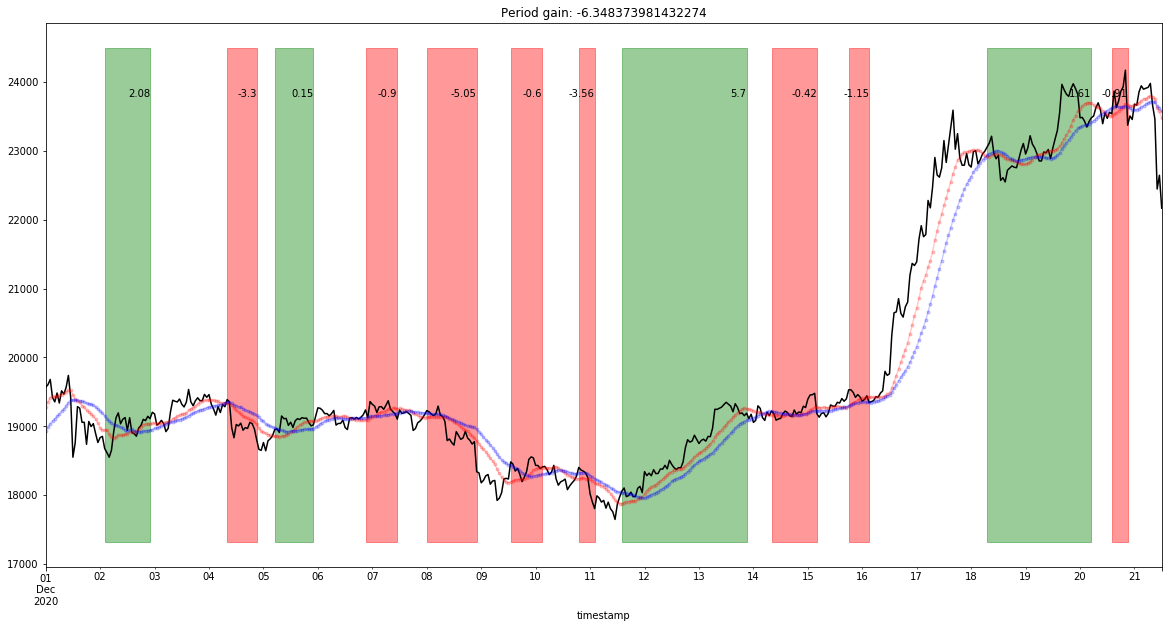

In [13]:
plot_timeline_month(model, 12)

In [30]:
params = {'delta_buy': [0.001, 0.002, 0.003],
          'delta_sell': [-.001, -.002, -.003]
        }

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
gs = GridSearchCV(model, params, cv=2, verbose=10, n_jobs=2)

In [33]:
gs.fit(np.zeros([100,2]),np.ones(100))

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   31.6s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:  4.7min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=<__main__.DMA_Trader object at 0x7feb46223710>,
             iid='deprecated', n_jobs=2,
             param_grid={'delta_buy': [0.001, 0.002, 0.003],
                         'delta_sell': [-0.001, -0.002, -0.003]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [34]:
gs.best_score_

49.90147060594851

In [35]:
gs.best_params_

{'delta_buy': 0.001, 'delta_sell': -0.003}

In [36]:
!pip install hyperopt

     |████████████████████████████████| 965 kB 3.9 MB/s eta 0:00:01


In [37]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials
import hyperopt

In [87]:
space = {
    'period_short': hp.choice('period_short', [14]),
    'period_long': hp.choice('period_long', [25]),
    'delta_buy': hp.loguniform('delta_buy', -6, -1),
    'delta_sell': -hp.loguniform('delta_sell', -6, -1)
}

In [90]:
def objective(params):
    print(params)
    model = DMA_Trader(mode='sim',
                     panic= -0.03,
                     interval_group='1h', 
                     interval_source='1h',
                     start_time=datetime.fromisoformat('2020-01-01'),
                     **params
                     )

    model.evaluate()

    return -model.score(1,1)

In [91]:
tpe_trials = Trials()

best = fmin(fn=objective,
            space=space,
            trials = tpe_trials,
            verbose=1,
            algo=hyperopt.tpe.suggest,
            return_argmin=False,
            max_evals=1000)

{'delta_buy': 0.2552398616249682, 'delta_sell': -0.11784817615990884, 'period_long': 25, 'period_short': 14}
{'delta_buy': 0.01756866407964455, 'delta_sell': -0.08360221277857201, 'period_long': 25, 'period_short': 14}
{'delta_buy': 0.007082405526625272, 'delta_sell': -0.004820213861994766, 'period_long': 25, 'period_short': 14}
{'delta_buy': 0.012342503182577014, 'delta_sell': -0.013007651259209108, 'period_long': 25, 'period_short': 14}
{'delta_buy': 0.20907529279335318, 'delta_sell': -0.03818885609284228, 'period_long': 25, 'period_short': 14}
{'delta_buy': 0.32998691914166134, 'delta_sell': -0.01524794445025241, 'period_long': 25, 'period_short': 14}
{'delta_buy': 0.08593246369911338, 'delta_sell': -0.010263668132339478, 'period_long': 25, 'period_short': 14}
{'delta_buy': 0.02651675752776177, 'delta_sell': -0.010412779762395633, 'period_long': 25, 'period_short': 14}
{'delta_buy': 0.027491121368499356, 'delta_sell': -0.008704169036930208, 'period_long': 25, 'period_short': 14}
{'d

KeyboardInterrupt: 

## Auxiliar 

In [76]:
a = hp.choice('max_depth', list(np.arange(1, 31)))
b = hp.loguniform('learning_rate', -6, -.5)

In [77]:
from hyperopt.pyll.stochastic import sample

In [78]:
result=[]
for i in range(1000):
    result.append(sample(b))

In [79]:
import matplotlib.pyplot as plt

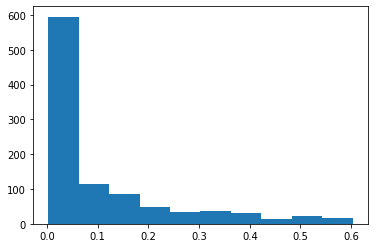

In [80]:
plt.hist(result); plt.show()